# MGSC 695: AI and DL 2 Final Project
# Video Classification and Human Activity Recognition

**Import** **Libraries** 

In [46]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Set random seeds

In [47]:
seed = 101
np.random.seed(seed=seed)
random.seed(seed)
tf.random.set_seed(seed)

**Import** **Data**

In [48]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

File ‘UCF50.rar’ already there; not retrieving.



**Data Preprocessing**

In [49]:
image_height, image_width = 32, 32
max_images_per_class = 6000

dataset_directory = "UCF50"

# Select 5 categories
classes_list = ['TennisSwing','JumpRope','PushUps','Lunges','JumpingJack']

#classes_list = ['TennisSwing','PlayingGuitar','PushUps','Lunges','JumpingJack']
model_output_size = len(classes_list)

**Extract, Resize and Normalize frames**

Generate the frames from video that specified the video path and resize and normalize the frames, return the list of frames.


In [50]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    while True:
        success, frame = video_reader.read() 

        if not success:
            break
        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

**Organizing data**

We create the datasets that can extract and randomly select 3000 frames (`max_images_per_class`) from each class as `features`, and then we label the frames by their classes as `labels`.

The function `create_dataset` will return the frames (`features`) and the classes (`labels`).

In [51]:
def create_dataset():

    temp_features = [] 
    features = []
    labels = []

    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
            frames = frames_extraction(video_file_path)
            temp_features.extend(frames)
        features.extend(random.sample(temp_features, max_images_per_class))
        labels.extend([class_index] * max_images_per_class)
        temp_features.clear()
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [52]:
features, labels = create_dataset()

Extracting Data of Class: TennisSwing
Extracting Data of Class: JumpRope
Extracting Data of Class: PushUps
Extracting Data of Class: Lunges
Extracting Data of Class: JumpingJack


In [53]:
# Categorizing
one_hot_encoded_labels = to_categorical(labels)

**Split Data into Train and Test**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed)

**Modelling**

Simple CNN with layers

In [55]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding="same", input_shape = (image_height, image_width, 3)))
model.add(MaxPooling2D(pool_size = (3, 3)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (3, 3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(model_output_size, activation = 'softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer = 'Adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 32)          128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

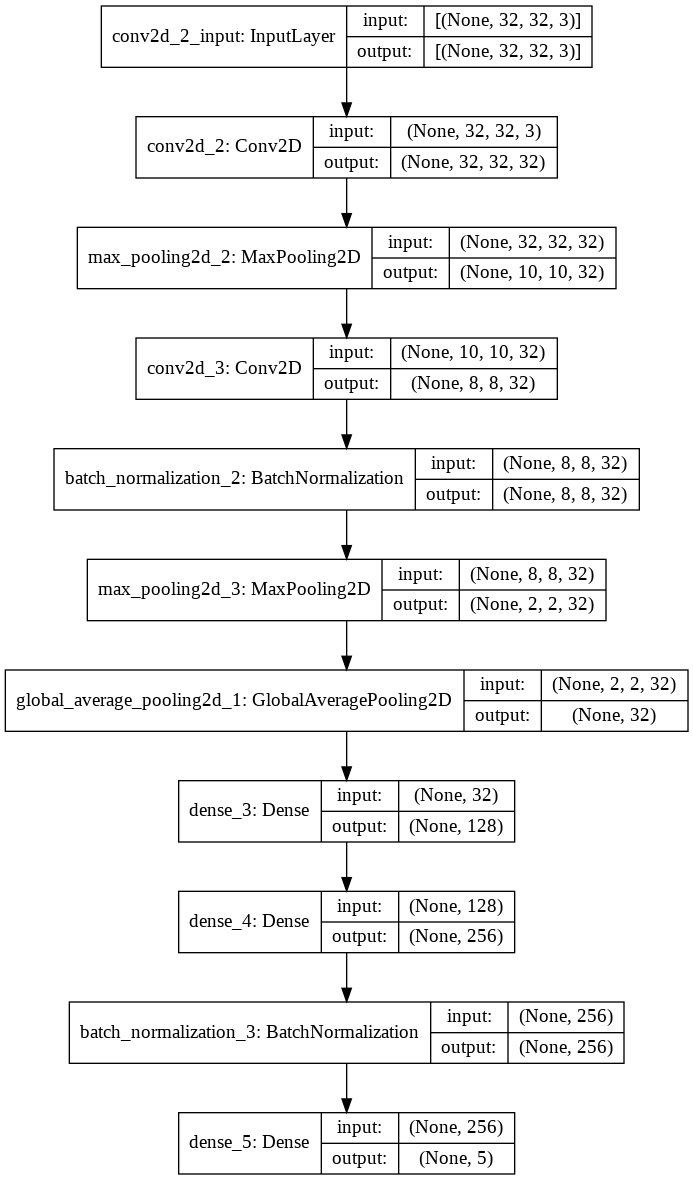

In [56]:
#Check model structure 
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Train the Model**

In [57]:
callback = EarlyStopping(monitor = 'val_loss', patience = 2, mode = 'min', restore_best_weights = True)
history = model.fit(x=X_train,y=y_train, epochs=20, batch_size = 4, validation_data=(X_test,y_test), callbacks = [callback])

Epoch 1/20
6000/6000 [==============================] - 23s 4ms/step - loss: 0.6937 - accuracy: 0.7474 - val_loss: 0.4771 - val_accuracy: 0.8413
Epoch 2/20
6000/6000 [==============================] - 21s 4ms/step - loss: 0.3941 - accuracy: 0.8677 - val_loss: 0.2202 - val_accuracy: 0.9255
Epoch 3/20
6000/6000 [==============================] - 21s 4ms/step - loss: 0.3150 - accuracy: 0.8988 - val_loss: 0.3532 - val_accuracy: 0.8973
Epoch 4/20
6000/6000 [==============================] - 21s 4ms/step - loss: 0.2534 - accuracy: 0.9183 - val_loss: 0.1501 - val_accuracy: 0.9463
Epoch 5/20
6000/6000 [==============================] - 21s 3ms/step - loss: 0.2340 - accuracy: 0.9279 - val_loss: 0.1308 - val_accuracy: 0.9533
Epoch 6/20
6000/6000 [==============================] - 21s 4ms/step - loss: 0.1787 - accuracy: 0.9481 - val_loss: 0.0797 - val_accuracy: 0.9702
Epoch 7/20
6000/6000 [==============================] - 21s 3ms/step - loss: 0.1840 - accuracy: 0.9448 - val_loss: 0.2232 - val_ac

**Model Loss and Accuracy Curves**

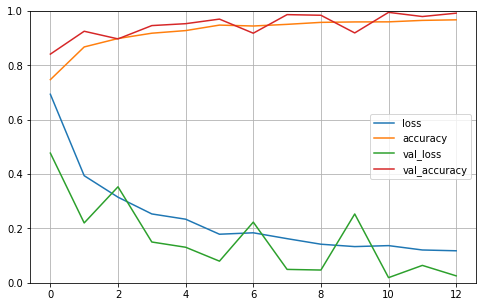

In [58]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

**Evaluate the model**

In [59]:
model_evaluation_history = model.evaluate(X_test, y_test)

188/188 [==============================] - 1s 3ms/step - loss: 0.0190 - accuracy: 0.9950


**Make predictions with the model**

Mount the student testing videos to Google Colab contents

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
def make_predictions(video_file_path):
    predictions_frames_count = 50
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)
    
    video_reader = cv2.VideoCapture(video_file_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count): 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        _ , frame = video_reader.read() 
        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]
    print("Predicted class name:", classes_list[predicted_labels_probabilities_averaged_sorted_indexes[0]])

    video_reader.release()

In [62]:
video_file_path = f'/content/drive/MyDrive/AI Human Movements/MMAstudents/PushUp.mp4'
make_predictions(video_file_path)

Predicted class name: PushUps


In [63]:
VideoFileClip(video_file_path).ipython_display(width = 300)

100%|██████████| 191/191 [00:01<00:00, 95.98it/s]
